In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

2025-12-19 22:54:22.178379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766184862.369490      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766184862.422535      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
im_width = 256
im_height = 256

# Paths to images and masks
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
train_files = [i.replace('_mask','') for i in mask_files]

# Check first 10 files
print("Image Files:", train_files[:10])
print("Mask Files:", mask_files[:10])

# Create DataFrame
df = pd.DataFrame({"filename": train_files, "mask": mask_files})

# Split data
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

Image Files: ['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
Mask Files: ['../input/lgg-mri-segmentation/kaggl

In [4]:
smooth = 100

def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask

def train_generator(data_frame, batch_size, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    target_size=(256,256),
                    seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="filename",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        seed=seed
    )
    
    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        seed=seed
    )
    
    train_gen = zip(image_generator, mask_generator)
    
    for img, mask in train_gen:
        img, mask = adjust_data(img, mask)
        yield img, mask

In [5]:
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    intersection = K.sum(y_truef * y_predf)
    return (2 * intersection + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [6]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    
    # Decoder
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    return Model(inputs=inputs, outputs=conv10)

model = unet()
model.summary()

I0000 00:00:1766184901.572642      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [7]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

# Data augmentation
train_generator_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=(im_height, im_width))
val_gen = train_generator(df_val, BATCH_SIZE, {}, target_size=(im_height, im_width))

# Compile model
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# Callbacks
callbacks = [
    ModelCheckpoint('unet_brain_mri_seg.keras', save_best_only=True, verbose=1)
]

# Train model
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=len(df_val) // BATCH_SIZE,
    callbacks=callbacks
)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50


I0000 00:00:1766184927.595712     109 service.cc:148] XLA service 0x7f1f840022e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766184927.596485     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766184928.863018     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1766184992.192036     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - binary_accuracy: 0.7314 - dice_coef: 0.0581 - iou: 0.0302 - loss: -0.0581Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02325, saving model to unet_brain_mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - binary_accuracy: 0.7328 - dice_coef: 0.0584 - iou: 0.0304 - loss: -0.0584 - val_binary_accuracy: 0.9891 - val_dice_coef: 0.0232 - val_iou: 0.0118 - val_loss: -0.0232
Epoch 2/50


E0000 00:00:1766185100.862629     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766185101.098068     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766185101.934250     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766185102.192581     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - binary_accuracy: 0.9800 - dice_coef: 0.1274 - iou: 0.0689 - loss: -0.1308
Epoch 2: val_loss improved from -0.02325 to -0.03889, saving model to unet_brain_mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 787ms/step - binary_accuracy: 0.9800 - dice_coef: 0.1276 - iou: 0.0690 - loss: -0.1309 - val_binary_accuracy: 0.9849 - val_dice_coef: 0.0389 - val_iou: 0.0200 - val_loss: -0.0389
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - binary_accuracy: 0.9834 - dice_coef: 0.1668 - iou: 0.0920 - loss: -0.1686

E0000 00:00:1766185261.423393     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1766185261.678335     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 3: val_loss improved from -0.03889 to -0.05451, saving model to unet_brain_mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 841ms/step - binary_accuracy: 0.9834 - dice_coef: 0.1669 - iou: 0.0920 - loss: -0.1686 - val_binary_accuracy: 0.9918 - val_dice_coef: 0.0525 - val_iou: 0.0274 - val_loss: -0.0545
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - binary_accuracy: 0.9878 - dice_coef: 0.2039 - iou: 0.1146 - loss: -0.2040
Epoch 4: val_loss improved from -0.05451 to -0.06560, saving model to unet_brain_mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 780ms/step - binary_accuracy: 0.9878 - dice_coef: 0.2039 - iou: 0.1147 - loss: -0.2041 - val_binary_accuracy: 0.8064 - val_dice_coef: 0.0656 - val_iou: 0.0342 - val_loss: -0.0656
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - binary_accuracy: 0.9905 - dice_coef: 0.2396 - iou: 0.1380 - loss: -0.2421
Epoch 5: val_loss improved from -0.06560 to -0.11127, saving model to unet_brain_mri_seg.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 779ms/s

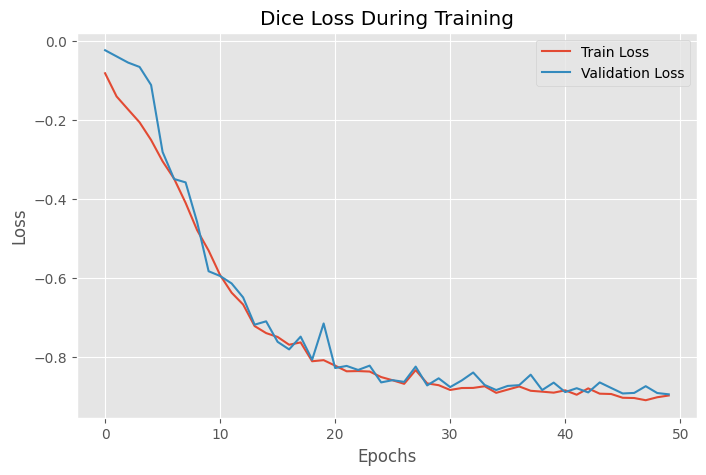

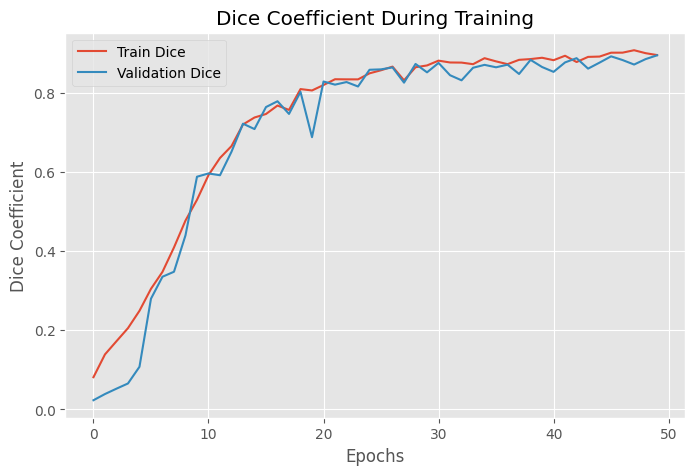

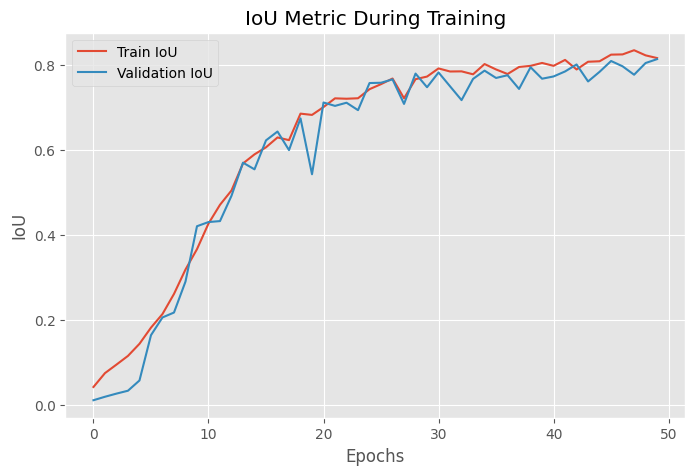

In [8]:
# Dice Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Dice Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Dice Coefficient
plt.figure(figsize=(8,5))
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Validation Dice')
plt.title("Dice Coefficient During Training")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.show()

# IoU
plt.figure(figsize=(8,5))
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.title("IoU Metric During Training")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

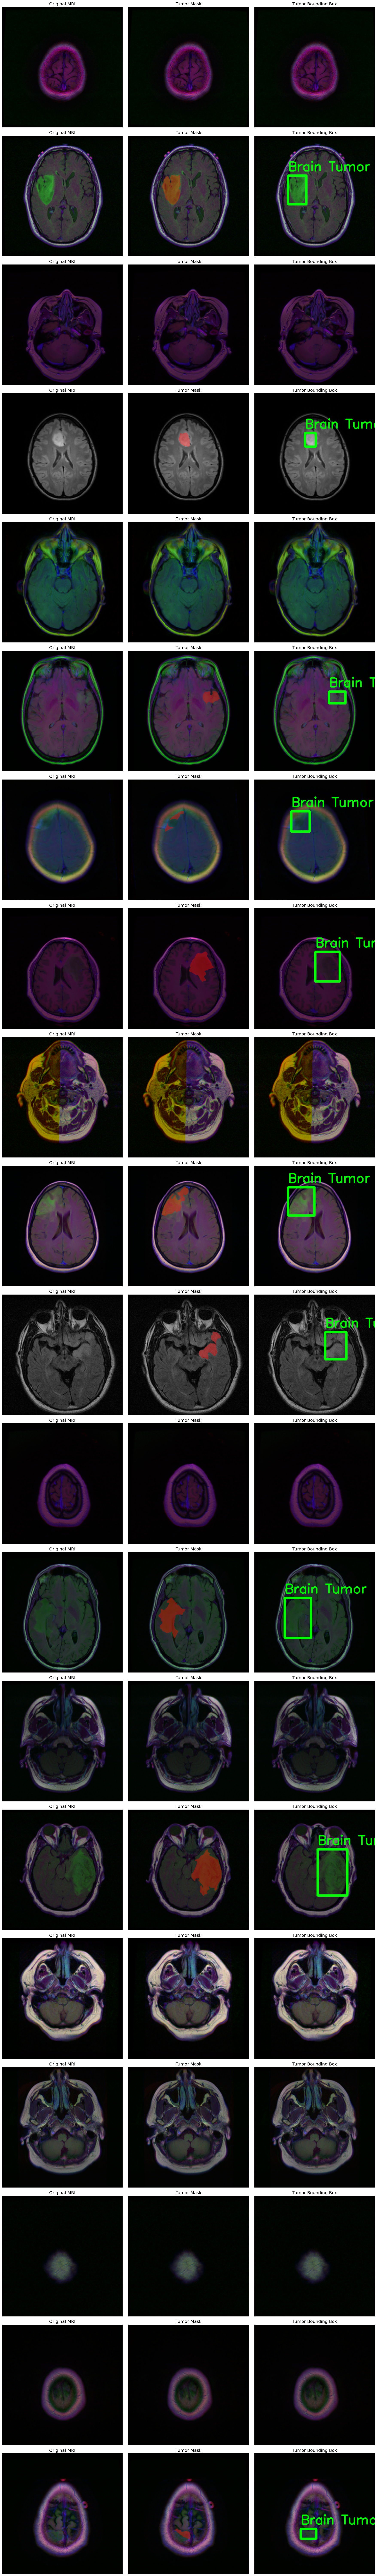

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

num_samples = 20

# randomly choose indices
random_indices = random.sample(range(len(df_test)), num_samples)

plt.figure(figsize=(18, 6 * num_samples))

for row, i in enumerate(random_indices):

    img_path = df_test['filename'].iloc[i]
    mask_path = df_test['mask'].iloc[i]

    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]))

    # Binary tumor mask
    mask_bin = (mask > 127).astype(np.uint8)

    # ---- Overlay tumor mask ----
    overlay = img_rgb.copy()
    overlay[mask_bin == 1] = [255, 0, 0]
    img_overlay = cv2.addWeighted(overlay, 0.4, img_rgb, 0.6, 0)

    # ---- Single bounding box from tumor ----
    img_box = img_rgb.copy()
    ys, xs = np.where(mask_bin == 1)

    if len(xs) > 0:
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        cv2.rectangle(
            img_box,
            (x_min, y_min),
            (x_max, y_max),
            (0, 255, 0),
            3
        )

        cv2.putText(
            img_box,
            "Brain Tumor",
            (x_min, y_min - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 255, 0),
            2
        )

    # ---- Plot ----
    plt.subplot(num_samples, 3, row*3 + 1)
    plt.imshow(img_rgb)
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(num_samples, 3, row*3 + 2)
    plt.imshow(img_overlay)
    plt.title("Tumor Mask")
    plt.axis("off")

    plt.subplot(num_samples, 3, row*3 + 3)
    plt.imshow(img_box)
    plt.title("Tumor Bounding Box")
    plt.axis("off")

plt.tight_layout()
plt.show()
